In [1]:
#Część funkcji przepisana w Cythonie, przetwórstwo 3000 obrazków spadło czasowo z 29->20 sekund
#Nowe cele:
#1) wywalić funkcję pythonowe, zamiast nich pełny cython - pragnę szybko prototypować CNN-a
#2) Znaleźć JEDYNE SŁUSZNE hiperparametry, inicjacje wag/learning rate
#3) Sprawdzić poprawność Conv_Back/pool_back - 
# niska stopa zwrotu z głębokiej warstwy backpropagacji po +-1000 iteracjach, poza tym wcześniej był tam błąd

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import re
import time
import cv2
import random
import math
from keras.datasets import mnist
import setuptools
%load_ext Cython

Using TensorFlow backend.
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Conda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym o

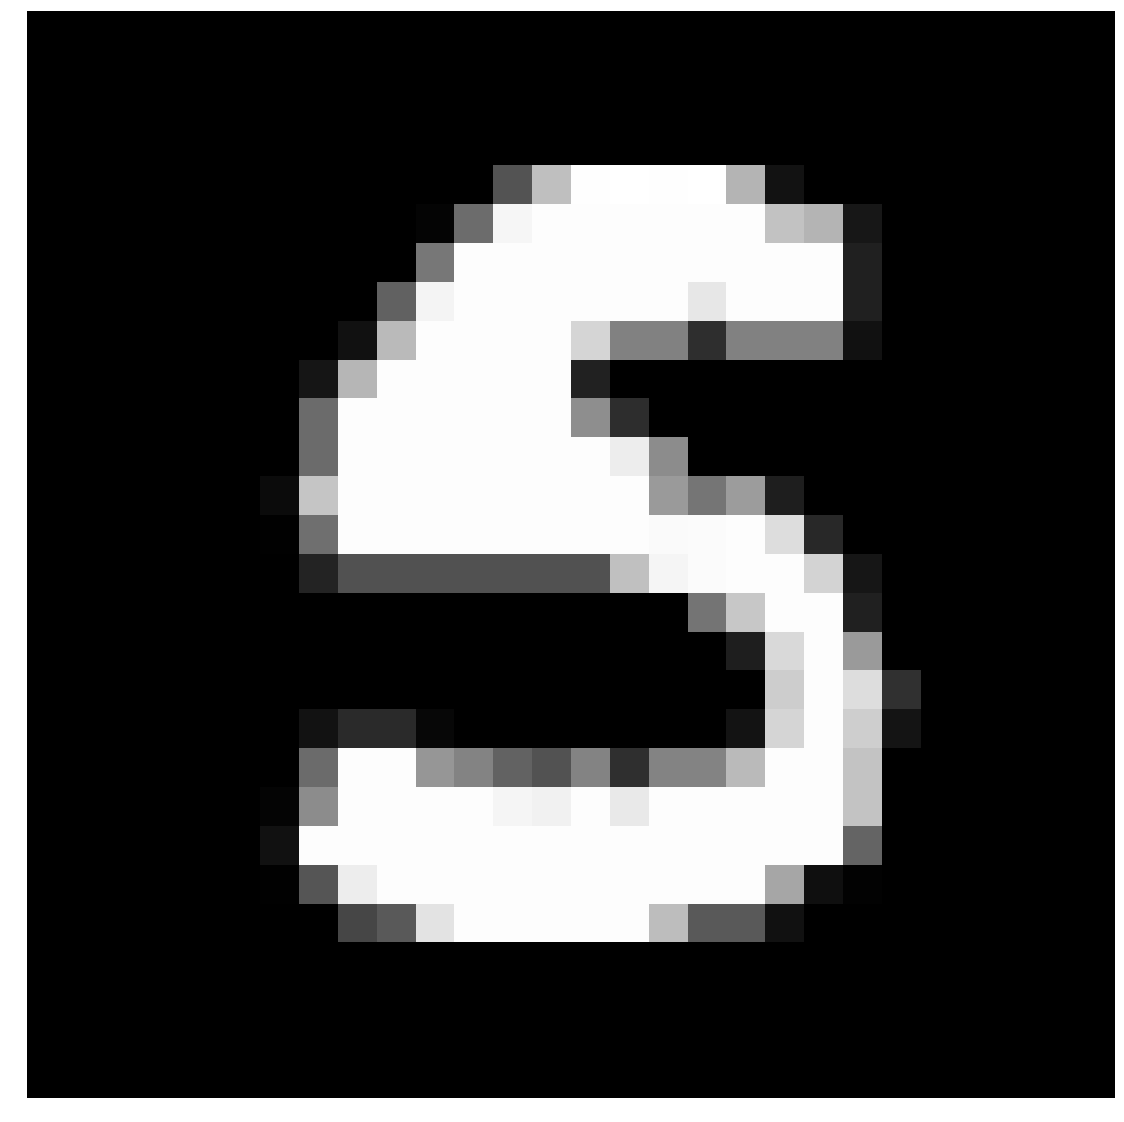

In [2]:
def disp(X):
    fig, ax=plt.subplots(1,1,figsize=(20,20))
    ax.imshow(X)
    ax.axis('off')
    plt.show()

(trainX, trainy), (testX, testy) = mnist.load_data()
zz=trainX[1997]
zz=zz.reshape(zz.shape[0], zz.shape[1], 1)
zz1=zz.copy()

zz=np.append(zz, zz1, axis=2)
zz=np.append(zz, zz1, axis=2)
zz=zz/255
disp(zz)
#print(zz.dtype, type(zz))

In [3]:
%%cython
import numpy as np
cimport numpy as np
from cpython cimport array
import array

def conv_forw(np.ndarray[double, ndim=3] f, np.ndarray[double, ndim=2] g):
    
    cdef int fl=f.shape[0], fr=f.shape[1], gl=g.shape[0], gr=g.shape[1]
    cdef np.ndarray[double, ndim=3] Z=np.zeros((fl-gl+1, fr-gr+1, f.shape[2]), dtype='float64')
    cdef int i=0, j=0, jj=0, ij=0, ii=0, Zl=Z.shape[0], Zr=Z.shape[1], Zs=Z.shape[2]
    
    for i in range(Zl):
        for j in range(Zr):
            for ij in range(Zs):
                for ii in range(3):
                    for jj in range(3):
                        if ((i+ii-1<fl) and (j+jj-1<fr) and (i+ii-1>=0) and (j+jj-1>=0)):
                            Z[i,j,ij]+=g[ii,jj]*f[i+ii-1,j+jj-1,ij]
    return Z

def my_pad(np.ndarray[double, ndim=3] X, int a, int b, int c, int d):
    cdef np.ndarray[double, ndim=3] Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    cdef int Xl=X.shape[0], Xr=X.shape[1], Xs=X.shape[2], i=0, j=0, i0=0, ij=0
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    
    """while (ij<Xs):
        i=b
        while (i<Xl+b):
            i0=i-b
            j=a
            while (j<Xr+a):
                Y[i,j,ij]=X[i0,j-a,ij]
                j+=1
            i+=1
        ij+=1"""
    
    return Y

def pool_forw(np.ndarray[double, ndim=3] X, np.ndarray[int, ndim=1] mat):
    cdef int Xl=X.shape[0], Xr=X.shape[1], Xs=X.shape[2], ff1, ff2
    cdef int t1=(mat[0]-Xl%mat[0])%mat[0]
    cdef int t2=(mat[1]-Xr%mat[1])%mat[1]
    
    cdef np.ndarray[double, ndim=3] Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    cdef int El=Y.shape[0]//mat[0], Er=Y.shape[1]//mat[1], Es=Y.shape[2], Yl=Y.shape[0], Yr=Y.shape[1], Ys=Y.shape[2], i, j
    cdef np.ndarray[double, ndim=3] Exit=np.zeros((El, Er, Es), dtype='float64')
    cdef np.ndarray[int, ndim=3] Pure=np.zeros((Yl, Yr, Ys), dtype='int32')
    
    """
    cdef np.ndarray[int, ndim=3] Truth2=np.zeros((El, Er, Es), dtype='int32')
    cdef np.ndarray[int, ndim=3] Truth=np.zeros((El, Er, Es), dtype='int32')
    for ij in range(Ys):
        for i in range(Yl):
            ff1=i//mat[0]
            for j in range(Yr):
                ff2=j//mat[1]
                if (Y[i,j,ij]>Exit[ff1,ff2,ij]):
                    Exit[ff1,ff2,ij]=Y[i,j,ij]
                    Pure[Truth[ff1,ff2,ij],Truth2[ff1,ff2,ij],ij]=0
                    Truth[ff1,ff2,ij]=i
                    Truth2[ff1,ff2,ij]=j
                    Pure[Truth[ff1,ff2,ij],Truth2[ff1,ff2,ij],ij]=1"""
    
    cdef np.ndarray[int, ndim=3] Truth2=np.zeros((El, Er, Es), dtype='int32')
    cdef np.ndarray[int, ndim=3] Truth=np.zeros((El, Er, Es), dtype='int32')
    
    for ij in range(Ys):
        for i in range(Yl):
            ff1=i//mat[0]
            for j in range(Yr):
                ff2=j//mat[1]
                if (Y[i,j,ij]>Exit[ff1,ff2,ij]):
                    Exit[ff1,ff2,ij]=Y[i,j,ij]
                    Pure[Truth[ff1,ff2,ij],Truth2[ff1,ff2,ij],ij]=0
                    Truth[ff1,ff2,ij]=i
                    Truth2[ff1,ff2,ij]=j
                    Pure[Truth[ff1,ff2,ij],Truth2[ff1,ff2,ij],ij]=1
    
    
    return (Exit, Pure)


"""def conv_back(np.ndarray[double, ndim=3] X, np.ndarray[double, ndim=2] mat, np.ndarray[double, ndim=3] Der):
    cdef np.ndarray[double, ndim=3] Z=np.zeros((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    cdef np.ndarray[double, ndim=2] matd=np.zeros((mat.shape[0], mat.shape[1]), dtype='float64')
    cdef int i=0, j=0, ai=0, aj=0, ml=mat.shape[0], mr=mat.shape[1], Dl=Der.shape[0], Dr=Der.shape[1]
    cdef double zz
    cdef np.ndarray[double, ndim=3] ff=np.zeros((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    #print(ml,mr,Dl,Dr)
    
    for i in range(ml):
        for j in range(mr):
            for ai in range(Dl):
                for aj in range(Dr):
                    zz=mat[i,j]*Der[ai,aj,0]
                    Z[i+ai,j+aj,0]+=zz
    
    for i in range(ml):
        for j in range(mr):
            ff=X.copy()
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)"""


    

In [4]:
#Tworzę większą tablicę zer i "wkładam" w nią X - array

"""def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y"""

"""#Konwolucja w przód
def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='float64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z"""

#Konwolucja w tył
def conv_back(X, mat, Der):
    Z=np.zeros(X.shape, dtype='float64')
    matd=np.zeros(mat.shape, dtype='float64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=X.copy()
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

#Relu za konwolucją
def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

#Pooling (dodaje odpowiedni padding przed transformacją)
"""def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)"""

#Pooling w tył
def pool_back(X, mat, dim):
    Y=np.zeros((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0
    
def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def rell_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def rell_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    
    for i in range(pred.shape[0]):        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.000001):
                pred[i,0]=0.000001
            elif(pred[i,0]>0.999999):
                pred[i,0]=0.999999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
        if (pred[i,0]<0.000001):
            pred[i,0]=0.000001
        elif(pred[i,0]>0.999999):
            pred[i,0]=0.999999
        
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
    return (der, summ)



In [121]:
#ccn - learning rate, loopz - number of iterations, epokz - number of epochs, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.002
loopz=60000
epokz=5
streetcleaner=1690
#Matt - convolution matrices
matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([0.15*np.random.normal(0, 1) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([0.15*np.random.normal(0, 1) for j in range(9)]).reshape(3,3)

#Weights and biases
w1=np.asmatrix(np.asarray([0.15*np.random.normal(0, 1) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
bw1=0.15*np.random.normal(0, 1)
#w2=np.asmatrix(np.asarray([np.random.uniform(-4*math.sqrt(1/5), 4*math.sqrt(1/5)) for j in range(10*20)]).reshape(10,20))
w2=np.asmatrix(np.asarray([0.15*np.random.normal(0, 1) for j in range(10*20)]).reshape(10,20))
bw2=0.15*np.random.normal(0, 1)

#Random matrices for random tasks
m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10
Face1=[0]*10

#Matrix with results
sk=[0]*(loopz*epokz)
t1=time.time()

#Iterations and epochs
for ii in range(epokz):
    for jj in range(loopz):
        #Read Imidż
        img=trainX[jj]
        img=img/255
        img=img.reshape(img.shape[0], img.shape[1], 1)

        #Forw - Konwolucja, Relu, Pooling

        for i in range(10):
            m2[i]=conv_forw(img, matt[i])
            m3[i]=relu(m2[i])
            m4[i], Face1[i]=pool_forw(m3[i], np.asarray([2,2]).astype('int32'))
            m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])


        #Forw - 2*FC na macierzach
        kk=np.asarray(m8)
        m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
        #print(len(m9))

        s1=w1*m9+bw1
        #s2=sigmoid_forw(s1)
        s2=rell_forw(s1)
        s3=w2*s2+bw2
        s4=sigmoid_forw(s3)


        #Koszt
        dp=np.asarray([0]*10).reshape(10, 1)
        dp[trainy[jj],0]=1
        der, suma=cost(dp, s4)
        sk[loopz*ii+jj]=suma
        #print(suma)

        #Back - 2.FC
        dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
        weight_delta2=dk2*s2.T
        bw2_delta=sum(dk2)[0,0]
        dk1=w2.T*dk2

        #Back - 1.FC
        #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
        dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
        weight_delta1=dk1*m9.T
        bw1_delta=sum(dk1)[0,0]
        dk0=w1.T*dk1


        #Back - 2*Konw, RElu, Pooling
        #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
        dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])


        for i in range(10):
            #mtb5[i]=pool_back(mtb6[i], (2,2), Face1[i])
            mtb5[i]=pool_back(dkl[i], (2,2), Face1[i])
            cz=m3[i].shape
            nw=mtb5[i].shape
            mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
            mtb4[i]=relu_back(m3[i], mtb5[i])
            mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])
            matt[i]-=Dr*ccn

        w1-=weight_delta1*ccn
        bw1-=bw1_delta*ccn
        w2-=weight_delta2*ccn
        bw2-=bw2_delta*ccn
        #matt2-=Dr2*ccn


    t2=time.time()
    print(t2-t1)
    print(s4)

413.66692662239075
[[6.97968352e-03]
 [1.39143550e-05]
 [3.67797042e-05]
 [1.05909608e-04]
 [4.10796214e-04]
 [5.84958713e-03]
 [3.62326434e-05]
 [7.82743360e-04]
 [8.38495030e-01]
 [3.61052273e-03]]
808.3251979351044
[[1.52242794e-03]
 [1.00000000e-06]
 [1.76530127e-06]
 [1.04128466e-05]
 [4.98750798e-04]
 [2.81722736e-03]
 [1.84286220e-06]
 [8.56979756e-04]
 [9.59411082e-01]
 [4.93328780e-03]]
1221.8614947795868
[[2.27171776e-03]
 [1.00000000e-06]
 [1.37267220e-06]
 [1.00000000e-06]
 [3.34746452e-05]
 [2.59377921e-04]
 [1.00000000e-06]
 [2.02561004e-04]
 [9.83248123e-01]
 [1.26313429e-03]]
1631.824943304062
[[4.10695730e-03]
 [1.00000000e-06]
 [1.11338133e-06]
 [1.00000000e-06]
 [3.22842197e-05]
 [2.81164484e-04]
 [1.00000000e-06]
 [1.11465471e-04]
 [9.80920017e-01]
 [1.12696209e-03]]
2041.9233996868134
[[6.11288002e-03]
 [1.00000000e-06]
 [2.52106287e-06]
 [1.04738919e-06]
 [2.63922287e-05]
 [4.58796776e-04]
 [1.00000000e-06]
 [1.78707607e-04]
 [9.66161226e-01]
 [1.25330602e-03]]


In [15]:
#pool_forw(m3[i], (2,2))
"""Y=m3[i].copy()
mat=(2,2)
Bleeding_One1=Y[list(range(0, Y.shape[0], mat[0]))][:,list(range(0, Y.shape[1], mat[1]))]
Bleeding_One2=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
print(sum(Bleeding_One1==Bleeding_One2))"""
print(Dr)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


(10, 20)


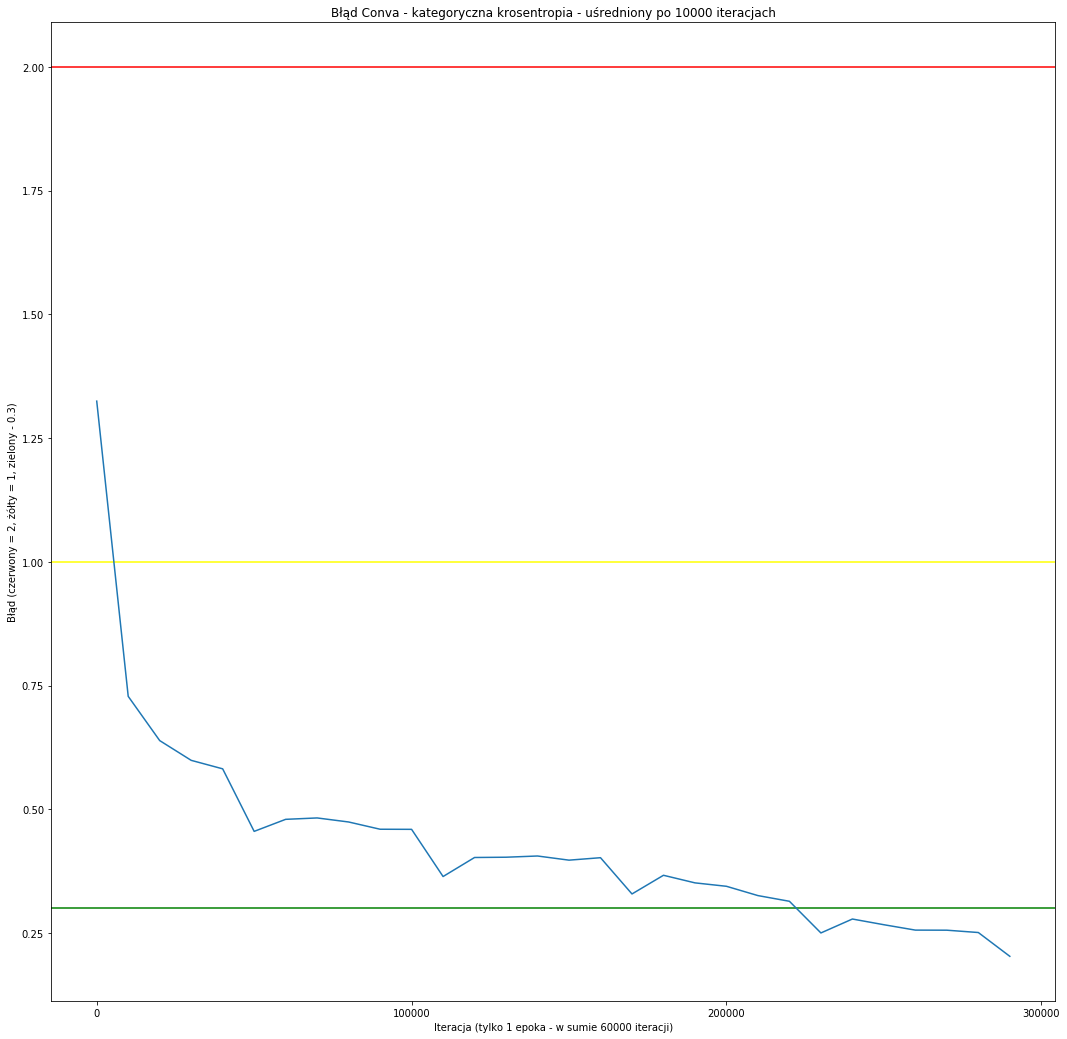

In [123]:
print(w2.shape)
fig, ax=plt.subplots(1, 1, figsize=(18,18))
dt=loopz*epokz
kgbo=10000
dt2=dt//kgbo
ss=10

dkkk=[0]*dt2
for i in range(dt2):
    dkkk[i]=sum(sk[i*kgbo:(i+1)*kgbo])/kgbo

ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach'.format(kgbo))
ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
ax.set_xticklabels(range(0, dt+1, kgbo*ss))
ax.set_xticks(range(0, dt//kgbo+1, ss))
ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)'.format(loopz))
ax.axhline(2, color='red')
ax.axhline(1, color='yellow')
ax.axhline(0.3, color='green')
ax.plot(dkkk)
plt.show()

In [124]:
num=10000
won=0
dp2=np.zeros((10,10), dtype='int64')

for jj in range(num):
    img=testX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""

    m2=[0]*10
    m3=[0]*10
    m4=[0]*10
    m8=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], np.asarray([2,2]).astype('int32'))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])

    """m5=[0]*10
    m6=[0]*10
    m7=[0]*10
    #Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""


    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9#+bw1
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2#+bw2
    s4=sigmoid_forw(s3)

    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[testy[jj],0]=1
    der, suma=cost(dp, s4)
    mxi=0
    for i in range(10):
        if (s4[i,0]>s4[mxi,0]):
            mxi=i
    if (mxi==testy[jj]):
        won+=1
    
    dp2[mxi,testy[jj]]+=1
    #print(mxi, testy[jj])
print('Skutecznosc na {} testach: {}'.format(num, won/num))

Skutecznosc na 10000 testach: 0.9659


[[ 971    0    8    1    1    8   10    3    7   11]
 [   0 1122    5    0    1    1    3    6    0    5]
 [   0    1  980    3    5    0    0   17    1    0]
 [   0    4    8  991    0    9    0    6    7    9]
 [   0    0    6    0  955    0    4    5    3   11]
 [   2    0    0    4    0  857   12    1    2    2]
 [   0    3    2    0    6    4  922    0    2    0]
 [   1    0    6    1    0    1    0  952    3    2]
 [   5    4   15    7    2   10    7    5  943    3]
 [   1    1    2    3   12    2    0   33    6  966]]


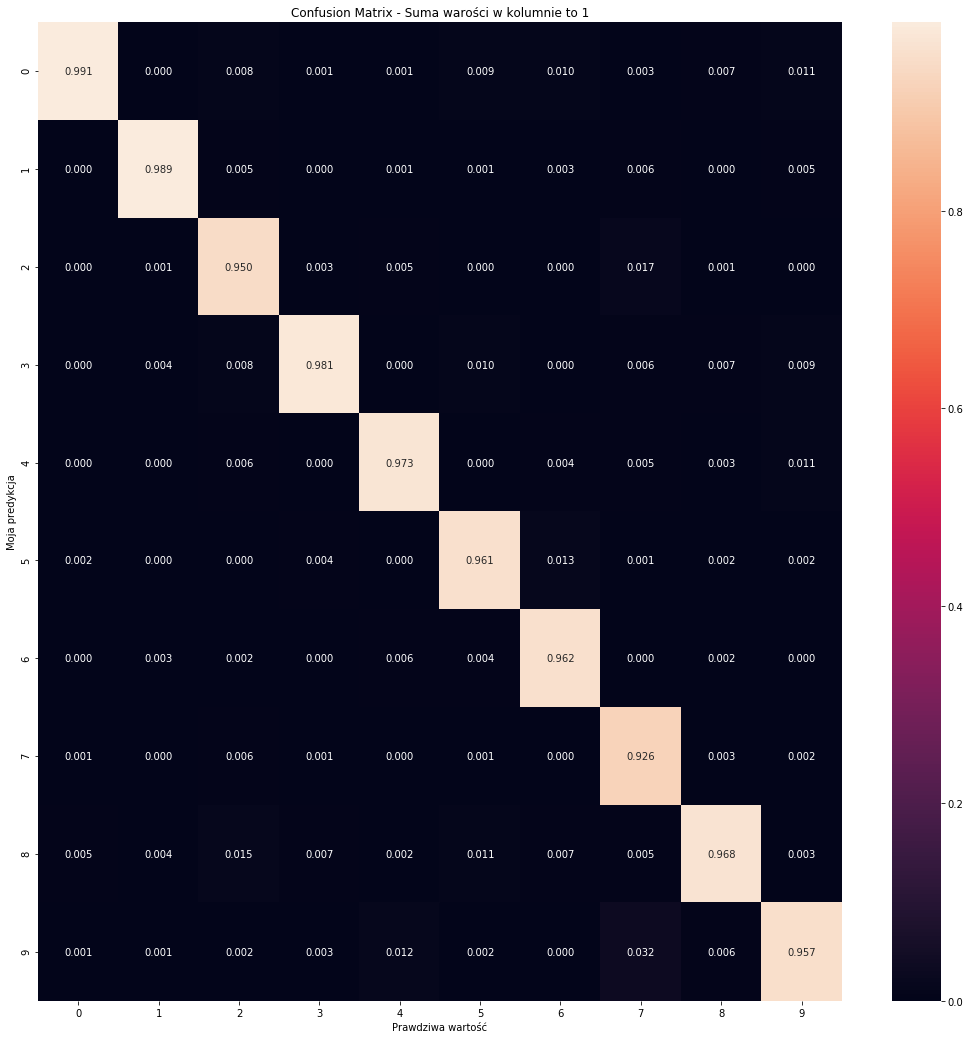

In [125]:
dk2=dp2*0
dk2=dk2.astype('float64')
liss=[0]*10
for i in range(dp2.shape[1]):
    liss[i]=sum(dp2[:,i])
    
for j in range(dk2.shape[1]):
    for i in range(dk2.shape[0]):
        dk2[i,j]=dp2[i,j]/liss[j]


print(dp2)


fig,ax=plt.subplots(1, 1, figsize=(18,18))
sns.heatmap(dk2, ax=ax, annot=True, fmt='.3f')
ax.set_xlabel('Prawdziwa wartość')
ax.set_ylabel('Moja predykcja')
ax.set_title('Confusion Matrix - Suma warości w kolumnie to 1')
plt.show()

In [23]:
#Hyperparameter tuning dla intelektualnej biedoty - zwykły grid syrcz, dalej vizualizacja
#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
loopz=1200
conn=np.asarray(list(range(1, 15, 1)))/50
to_check=[0.01,0.005,0.001,0.0005,0.0001]
sk=np.zeros((len(to_check), len(conn), loopz), dtype='float64')


m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10
Face1=[0]*10


for last_exit_for_the_lost in range(len(to_check)):
    for k in range(len(conn)):
        ccn=to_check[last_exit_for_the_lost]
        streetcleaner=1690

        matt=[0]*10
        matt2=[0]*10
        for i in range(10):
            matt[i]=conn[k]*np.asarray([np.random.normal(0, 1) for j in range(9)]).reshape(3,3)
            matt2[i]=conn[k]*np.asarray([np.random.normal(0, 1) for j in range(9)]).reshape(3,3)

        #img=cv2.imread("E:\W3\GGHard.jpg")
        w1=conn[k]*np.asmatrix(np.asarray([np.random.normal(0, 1) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
        bw1=conn[k]*np.random.normal(0, 1)
        #w2=np.asmatrix(np.asarray([np.random.uniform(-4*math.sqrt(1/5), 4*math.sqrt(1/5)) for j in range(10*20)]).reshape(10,20))
        w2=conn[k]*np.asmatrix(np.asarray([np.random.uniform(0, 1) for j in range(10*20)]).reshape(10,20))
        bw2=conn[k]*np.random.normal(0, 1)


        t1=time.time()
        for jj in range(loopz):
            img=trainX[jj]
            img=img/255
            img=img.reshape(img.shape[0], img.shape[1], 1)

            #Forw - Konwolucja, Relu, Pooling

            for i in range(10):
                m2[i]=conv_forw(img, matt[i])
                m3[i]=relu(m2[i])
                m4[i], Face1[i]=pool_forw(m3[i], np.asarray([2,2]).astype('int32'))
                m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])


            #Forw - 2*FC na macierzach
            kk=np.asarray(m8)
            m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
            #print(len(m9))

            s1=w1*m9+bw1
            #s2=sigmoid_forw(s1)
            s2=rell_forw(s1)
            s3=w2*s2+bw2
            s4=sigmoid_forw(s3)


            #Koszt
            dp=np.asarray([0.0]*10).reshape(10, 1)
            dp[trainy[jj],0]=1
            der, suma=cost(dp, s4)
            sk[last_exit_for_the_lost,k,jj]=suma
            #print(suma)

            #Back - 2.FC
            dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
            weight_delta2=dk2*s2.T
            bw2_delta=sum(dk2)[0,0]
            dk1=w2.T*dk2

            #Back - 1.FC
            #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
            dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
            weight_delta1=dk1*m9.T
            bw1_delta=sum(dk1)[0,0]
            dk0=w1.T*dk1


            #Back - 2*Konw, RElu, Pooling
            #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
            dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])


            for i in range(10):
                #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
                mtb5[i]=pool_back(dkl[i], (2,2), Face1[i])
                cz=m3[i].shape
                nw=mtb5[i].shape
                mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
                mtb4[i]=relu_back(m3[i], mtb5[i])
                mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])
                matt[i]-=Dr*ccn

            w1-=weight_delta1*ccn
            bw1-=bw1_delta*ccn
            w2-=weight_delta2*ccn
            bw2-=bw2_delta*ccn
            #matt2-=Dr2*ccn


        t2=time.time()
        print(t2-t1)

7.784413814544678
7.800013542175293
7.800013542175293
7.83121395111084
7.800013542175293
7.831213712692261
7.7844133377075195
7.815613508224487
7.784413576126099
7.800014019012451
7.831213712692261
7.815613746643066
7.784413576126099
7.815613508224487
7.800013542175293
7.800014019012451
7.768813610076904
7.768813848495483
7.815613746643066
7.784413814544678
7.800013542175293
7.831213712692261
7.784413576126099
7.831213712692261
7.83121395111084
7.9092137813568115
7.800013780593872
7.815613508224487
7.784413576126099
7.800013780593872
7.800013542175293
7.815613746643066
7.800013780593872
7.940413951873779
8.263872146606445
8.296206951141357
8.102522850036621
8.003813982009888
7.8624138832092285
7.924813747406006
7.878013610839844
7.878013849258423
7.909214019775391
8.09641408920288
7.9092137813568115
8.049613952636719
8.002814292907715
7.878013610839844
7.924813985824585
7.940413951873779
7.956014156341553
8.17441439628601
8.01841402053833
7.940413951873779
7.8624138832092285
7.81561374

In [22]:
print(suma)

11.760770044965248


(10, 20)


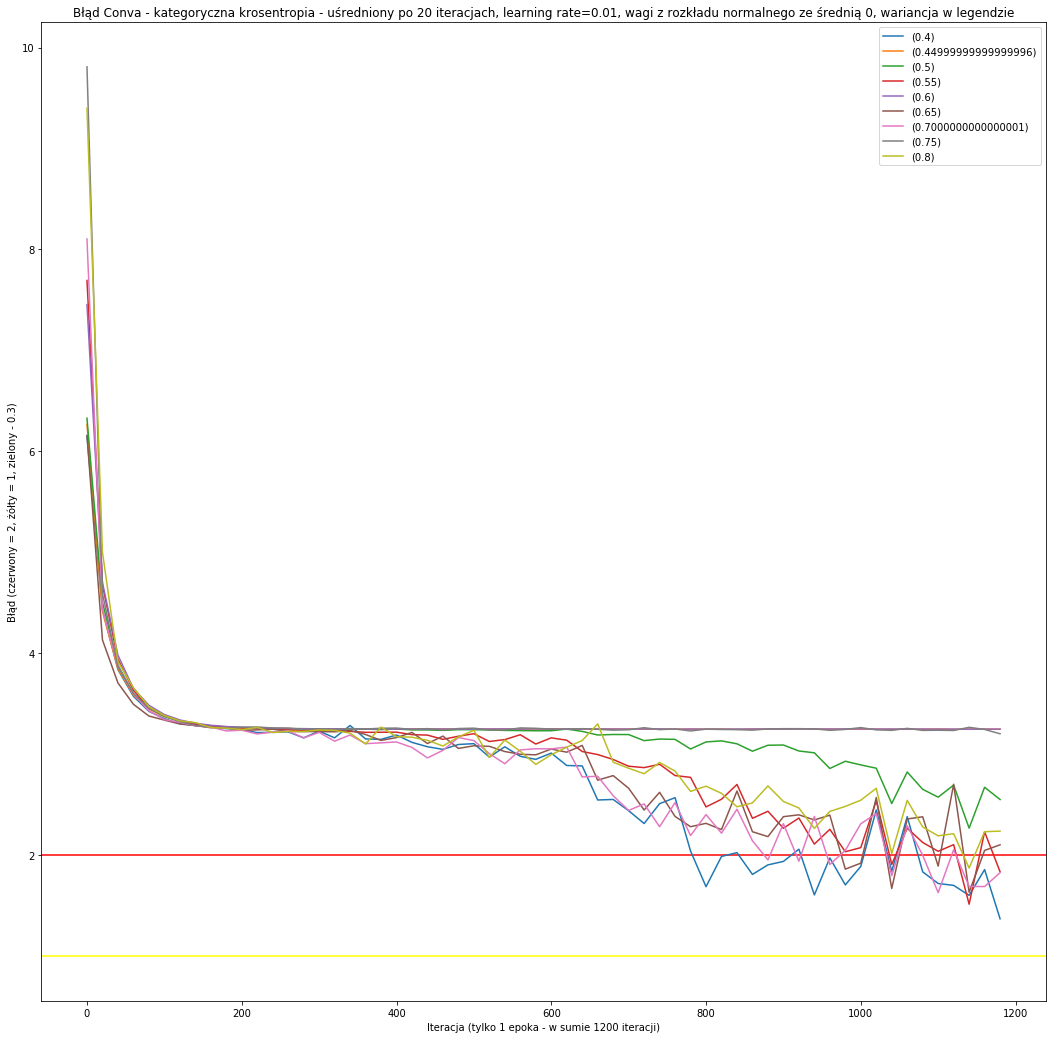

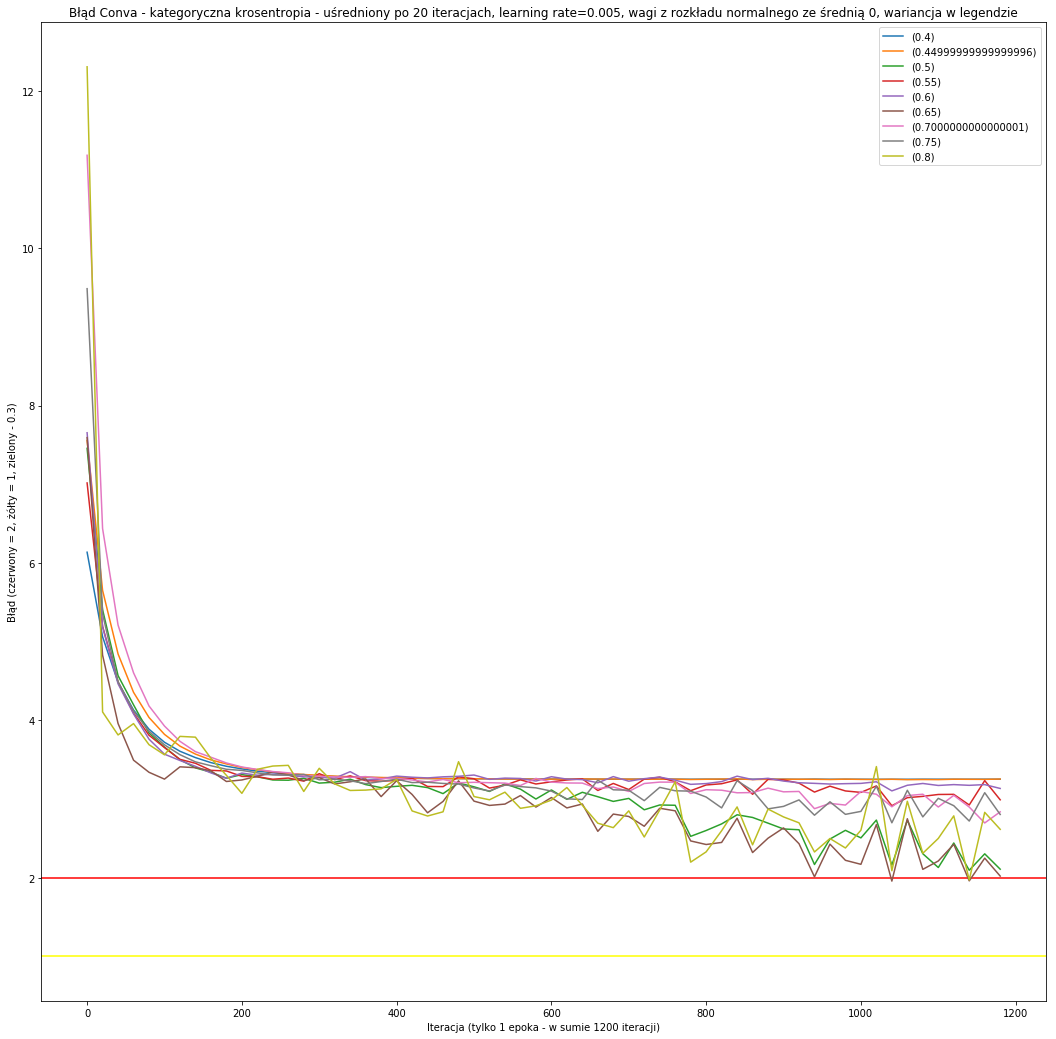

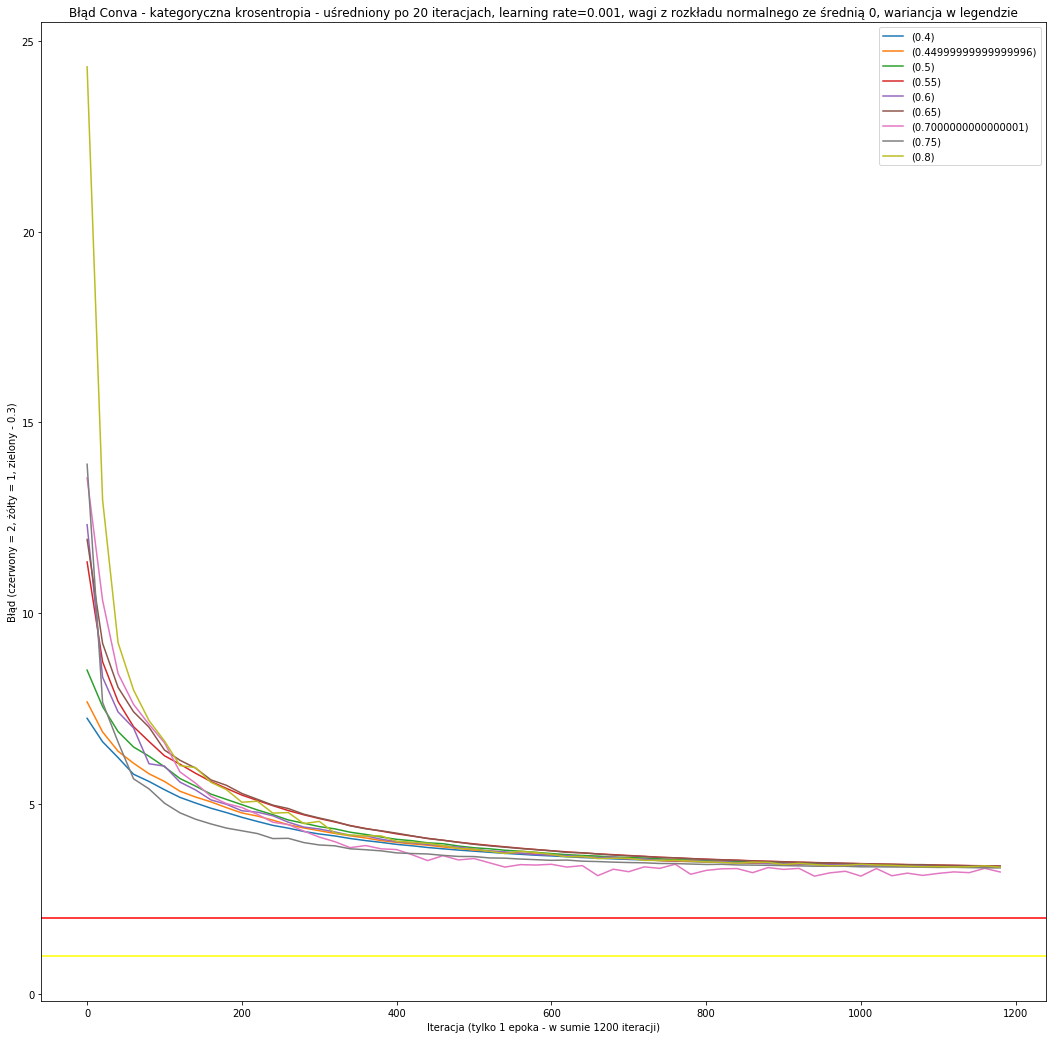

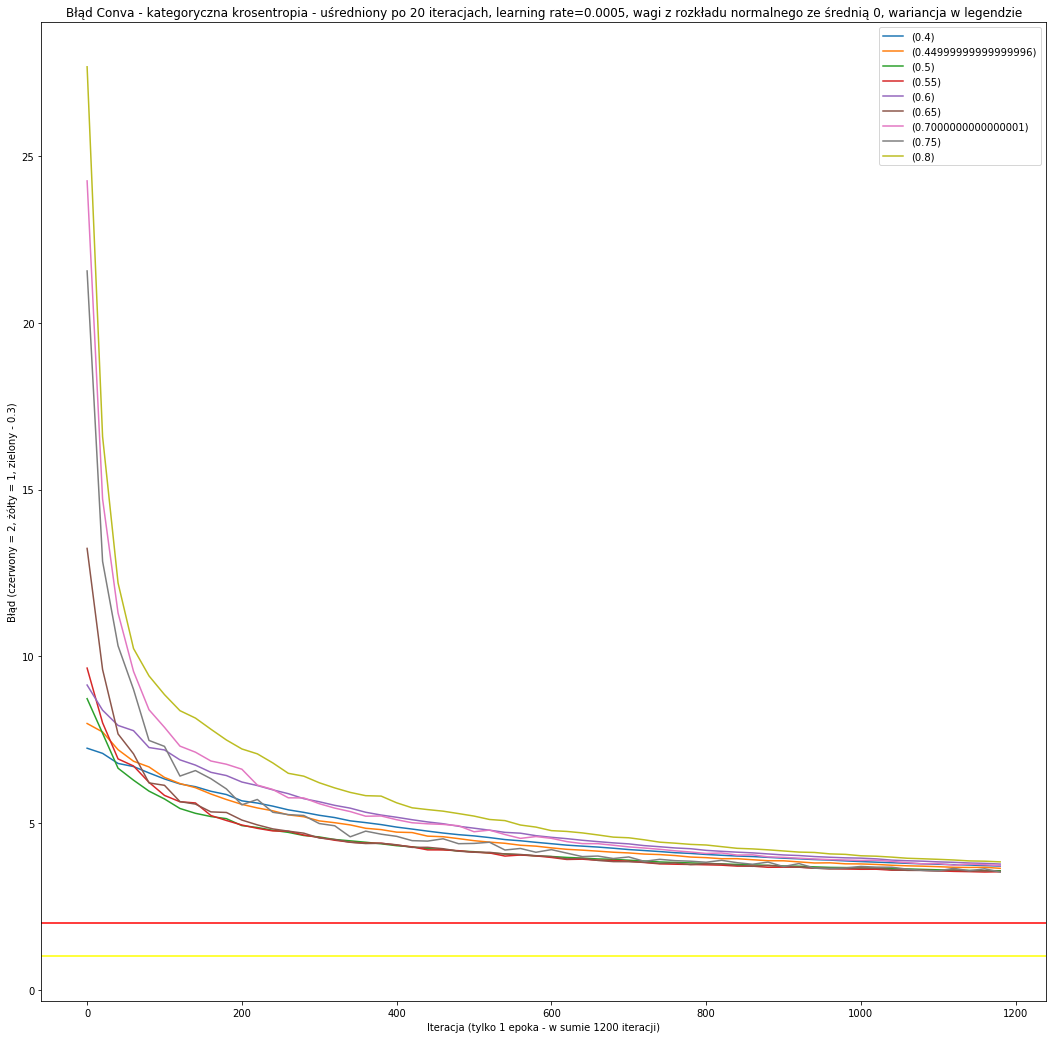

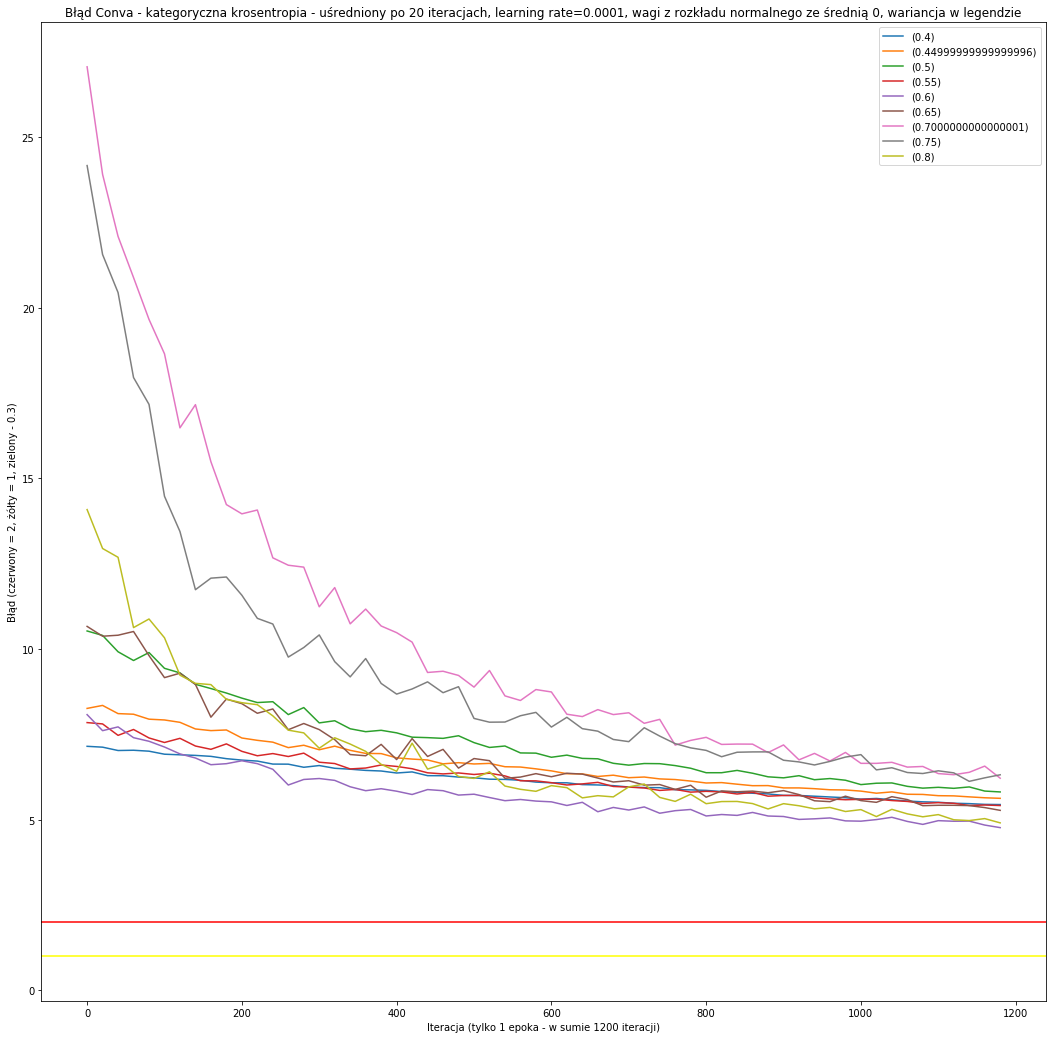

In [30]:
print(w2.shape)
dt=loopz
kgbo=20
dt2=dt//kgbo
ss=10

dkkk=np.zeros((len(to_check), len(conn), dt2), dtype='float64')

for ij in range(len(to_check)):
    for j in range(len(conn)):
        for i in range(dt2):
            dkkk[ij,j,i]=sum(sk[ij,j,i*kgbo:(i+1)*kgbo])/kgbo

#ax.axhline(0.3, color='green')
for ij in range(len(to_check)):
    fig, ax=plt.subplots(1, 1, figsize=(18,18))
    ax.set_title('Błąd Conva - kategoryczna krosentropia - uśredniony po {} iteracjach, learning rate={}, wagi z rozkładu normalnego ze średnią 0, wariancja w legendzie'.format(kgbo, to_check[ij]))
    ax.set_xlabel('Iteracja (tylko 1 epoka - w sumie {} iteracji)'.format(loopz))
    ax.set_xticklabels(range(0, loopz+1, kgbo*ss))
    ax.set_xticks(range(0, loopz//kgbo+1, ss))
    ax.set_ylabel('Błąd (czerwony = 2, żółty = 1, zielony - 0.3)'.format(loopz))
    ax.axhline(2, color='red')
    ax.axhline(1, color='yellow')
    
    for j in range(5, len(conn)):
        ax.plot(dkkk[ij,j], label='({})'.format(0.15+j/20))
        ax.legend()
    plt.show()
plt.show()

In [32]:
##Od tego miejsca śmieci do debugu
###
###
###


k1=np.asarray([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
k1=k1.reshape(k1.shape[0], k1.shape[1], 1)
mathr=np.asarray([[1,2,3],[-1,-2,-3],[-10,10,20]])
c1=conv_forw(k1, mathr)
#c1=c1.reshape(c1.shape[0], c1.shape[1])
kgb=pool_forw(k1, (2,2))

print(kgb[1].reshape(kgb[1].shape[0], kgb[1].shape[1]))


[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]]


In [139]:
dkk=[0]*10
for i in range(100):
    dkk[testy[i]]+=1
print(dkk)


#print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2].shape)
#print(print(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]))
#print(z)
#TT=(kk[3:kk.shape[0]-4,1:kk.shape[1]-2]==z)
#print(TT[TT==False])

[8, 14, 8, 11, 14, 7, 10, 15, 2, 11]


(1048, 698, 3) (7, 7)
2 2
(1050, 705, 3) (7, 7)
(150, 100)
150 100


In [17]:
mat=mymat
Y=np.ndarray((z.shape[0]*mat.shape[0], z.shape[1]*mat.shape[1]*3, z.shape[2]*2), dtype='float64')
t1=time.time()
for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
        for ij in range(z.shape[2]):
            Y[i:i+1,j,ij]=1
t2=time.time()
print(t2-t1)
print(Y.shape[0]*Y.shape[1]*Y.shape[2])

7.269612789154053
29625912


In [10]:
k=[random.random() for i in range(10)]
print(k)

[0.5984270187569013, 0.9671677742926911, 0.7976401137331915, 0.053760428992956966, 0.25749371422047285, 0.16253284123891132, 0.9060344103299387, 0.2756248627348449, 0.5445703657707015, 0.39006604163079217]


In [ ]:
z=cv2.imread("E:\W3\GGHard.jpg")
#z=z/255
mymat=np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
z=conv_forw(z, mymat)
z=relu(z)
t1=time.time()
z, dt=pool_forw(z,(7,7))
t2=time.time()
print(t2-t1)
print(dt.shape)
#z=pool(z,(7,7))

"""fig, ax=plt.subplots(1,1,figsize=(20,20))
ax.imshow(z)
ax.axis('off')
plt.show()"""

In [ ]:
def conv_forw(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_forw2(X, mat):
    Z=np.ndarray((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    Z=Z*0
    print(type(X))
    X=X.astype('int64')    
    
    print(Z.shape[0]*Z.shape[1]*mat.shape[0]*mat.shape[0])
    xz1=mat.shape[0]
    xz2=mat.shape[1]
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            ii=0
            while (ii<xz1):
                jj=0
                while(jj<xz2):
                    Z[i,j]=1
                    jj+=1
                ii+=1
    return Z
            
B=np.asarray([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kurl=r"E:\W3\GGHard.jpg"
kk=cv2.imread(kurl)

t1=time.time()
nightmare=conv_forw2(kk, B)
t2=time.time()
print(t2-t1)
t1=time.time()
nightmare2 = ndimage.convolve(kk.astype('int64'), B.reshape(3,3,1))
t2=time.time()
print(t2-t1)

fig, ax=plt.subplots(1,2,figsize=(22,22))
ax[0].imshow(nightmare2)
ax[0].axis('off')
ax[1].imshow(nightmare)
ax[1].axis('off')
plt.show()

In [ ]:
print(kk.shape)
print(nightmare2[1:nightmare2.shape[0]-1,1:nightmare2.shape[1]-1])
print(nightmare)

def relu(x):
    if (x<0):
        return 0
    return x

def pool_forward(X):
    Y=pd.Series([True]*X.shape[0])
    Y2=pd.Series([True]*X.shape[1])
    
    Y[Y.index%2==0]=False
    Y2[Y2.index%2==0]=False 
    KK1=X[Y][:,Y2]
    KK2=X[Y][:,~Y2]
    KK3=X[~Y][:,Y2]
    KK4=X[~Y][:,~Y2]
    
    Dt=KK1*0+1
    Exit=KK1
    Dt[Exit<KK2]=2
    Exit[Exit<KK2]=KK2[Exit<KK2]
    Dt[Exit<KK3]=3
    Exit[Exit<KK3]=KK3[Exit<KK3]
    Dt[Exit<KK4]=4
    Exit[Exit<KK4]=KK3[Exit<KK4]
    
    return (Dt, KK1)

t1=time.time()
Res, KK=pool_forward(nightmare)
t2=time.time()
print(t2-t1)

print(nightmare[:4,:4,0])

#Dodanie wersetu w 2 wymiarze
print(KK.shape)
s=[0]*KK.shape[0]*KK.shape[2]
s=np.asarray(s).reshape(KK.shape[0], 1, 3)
GG=np.append(KK, s, axis=1)
print(GG.shape)

In [98]:
n1, n2 = np.arange(5), np.arange(5)
Y=m7[0]
n1=np.arange(m7[0].shape[0])

f1=pd.Series([1]*Y.shape[0])
f2=pd.Series([1]*Y.shape[1])
f3=pd.Series([1]*Y.shape[2])

n1=np.asarray(f1[(f1.index%2)==0].index)
n2=np.asarray(f2[(f2.index%2)==1].index)
n3=np.asarray(f3.index)

m7[0][n1,n2]=13
print(m7[0][np.ix_(n1, n2,n3)].shape)
print(m7[0].shape)

(3, 3, 3)
(6, 6, 3)


In [119]:
print(math.exp(-100000))

0.0


In [71]:
print(matt)

[[[-1.80641111e-01  1.01303406e+00  5.68658521e-02]
  [-1.50180242e-01 -4.49518778e-01  2.29888229e-01]
  [-1.49464212e-01  1.79568202e-02  5.63098800e-01]]

 [[ 3.57100431e-01 -1.24985684e-01 -1.44566969e-01]
  [ 5.21873333e-01  9.49807180e-01  8.12153844e-01]
  [-1.77566089e-01 -6.69357460e-01  4.61081356e-01]]

 [[ 8.51013511e-01 -3.23042716e-01 -5.74604168e-01]
  [ 1.54445548e-01 -2.12365245e-01 -6.03171539e-01]
  [ 1.08646375e+00 -3.59921150e-01 -3.14678410e-01]]

 [[-3.09463601e-01 -8.49167675e-01  4.21892386e-01]
  [-9.78466819e-02  4.85793427e-01  4.07272130e-01]
  [-4.93156935e-01 -2.03789750e-01 -7.12313815e-02]]

 [[-8.53628217e-02 -7.04846645e-04  6.31339778e-03]
  [ 5.44888689e-01 -4.57835885e-01 -4.06130290e-01]
  [-7.09531689e-02 -4.13826322e-01  3.46471223e-01]]

 [[-3.29109786e-01  6.69617081e-01  4.80251536e-01]
  [-4.98654748e-01  5.22653924e-02 -4.02342825e-01]
  [ 3.54233047e-01 -4.11030534e-01 -4.91160409e-02]]

 [[-1.87180082e-01  8.45536081e-04  4.05606974e-02]


In [ ]:
##DIRT

#Tworzę większą tablicę zer i "wkładam" w nią X - array
def my_pad(X, a, b, c, d):    
    Y=np.zeros((X.shape[0]+b+d, X.shape[1]+a+c, X.shape[2]), dtype='float64')
    Y[b:X.shape[0]+b,a:X.shape[1]+a,:]=X
    return Y

def conv_forw(X, mat):
    Z=np.zeros((X.shape[0]-mat.shape[0]+1, X.shape[1]-mat.shape[1]+1, X.shape[2]), dtype='int64')
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            Z=Z+ff
    return Z

def conv_back(X, mat, Der):
    Z=np.ndarray((X.shape[0], X.shape[1], X.shape[2]), dtype='float64')
    matd=mat*0
    Z=Z*0
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*Der
            Z[i:Der.shape[0]+i,j:Der.shape[1]+j]=Z[i:Der.shape[0]+i,j:Der.shape[1]+j]+ff
    
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ff=mat[i,j]*X
            ff=ff[i:X.shape[0]-mat.shape[0]+i+1,j:X.shape[1]-mat.shape[1]+j+1]
            matd[i,j]=sum(sum(sum(np.multiply(ff, Der))))
    return (Z, matd)

def relu(X):
    Y=X.copy()
    Y[Y<0]=0
    return Y

def relu_back(X, Der):
    Sd=Der.copy()
    Sd[X<0.0000001]=0
    return Sd

def pool_forw(X, mat):
    t1=(mat[0]-X.shape[0]%mat[0])%mat[0]
    t2=(mat[1]-X.shape[1]%mat[1])%mat[1]
    
    Y=my_pad(X, t2//2, t1//2, (t2//2+t2%2), t1//2+t1%2)
    silver_in_blood=np.asarray([[0]*(Y.shape[1]//mat[1])]*(Y.shape[0]//mat[0]))
    
    Exit=np.zeros(Y.shape, dtype='float64')
    Exit=Exit[:(Exit.shape[0]//mat[0]),:(Exit.shape[1]//mat[1])]
    
    Truth=np.zeros(Y.shape, dtype='int64')
    Truth2=np.zeros(Y.shape, dtype='int64')
    Pure=np.zeros(Y.shape, dtype='float64')
    
    Truth=Truth[:(Truth.shape[0]//mat[0]),:(Truth.shape[1]//mat[1])]
    Truth2=Truth2[:(Truth2.shape[0]//mat[0]),:(Truth2.shape[1]//mat[1])]
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Bleeding_One=Y[list(range(i, Y.shape[0], mat[0]))][:,list(range(j, Y.shape[1], mat[1]))]
            #Bleeding_One=Y[np.ix_(list(range(0, Y.shape[0], mat[0])),list(range(0, Y.shape[1], mat[1])))]
            
            Truth[Exit<Bleeding_One]=i
            Truth2[Exit<Bleeding_One]=j
            Exit[Exit<Bleeding_One]=Bleeding_One[Exit<Bleeding_One]
    
    for i in range(Truth.shape[0]):
        for j in range(Truth.shape[1]):
            for ij in range(Truth.shape[2]):
                Pure[i*mat[0]+Truth[i,j,ij],j*mat[1]+Truth2[i,j,ij],ij]=1
    return (Exit, Pure)

def pool_back(X, mat, dim):
    Y=np.ndarray((X.shape[0]*mat[0], X.shape[1]*mat[1], X.shape[2]), dtype='float64')
    
    for i in range(mat[0]):
        for j in range(mat[1]):
            Y[np.ix_(np.asarray(list(range(i,Y.shape[0],mat[0]))),np.asarray(list(range(j,Y.shape[1],mat[1]))))]=X
    Y=Y*dim
    return Y


def sigmoid(x):
    try:
        s=1/(1+math.exp(-x))
        return s
    except:
        return 0
    
def sigmoid_forw(v):
    return np.asmatrix(np.apply_along_axis(sigmoid, 1, v).reshape(v.shape[0], 1))

def sigmoid_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: sigmoid(x)*(1-sigmoid(x)), 1, v).reshape(v.shape[0], 1))

def rell_forw(v):
    return np.asmatrix(np.apply_along_axis(lambda x: max(0.0, x), 1, v).reshape(v.shape[0], 1))

def rell_back(v):
    return np.asmatrix(np.apply_along_axis(lambda x: np.sign(max(0.0, x)), 1, v).reshape(v.shape[0], 1))

def cost(act, pred):
    summ=0
    der=pred*0
    
    for i in range(pred.shape[0]):        
        if ((pred[i,0]==0 and act[i,0]==0) or (pred[i,0]==1 and act[i,0]==1)):
            der[i,0]=0
        else:
            if (pred[i,0]<0.000001):
                pred[i,0]=0.000001
            elif(pred[i,0]>0.99999):
                pred[i,0]=0.99999
            der[i,0]=-act[i,0]/pred[i,0]+(1-act[i,0])/(1-pred[i,0])
        
        if (pred[i,0]<0.000001):
            pred[i,0]=0.000001
        elif(pred[i,0]>0.99999):
            pred[i,0]=0.99999
        
        summ=summ-act[i,0]*math.log(pred[i,0])-(1-act[i,0])*math.log(1-pred[i,0])
        
    return (der, summ)

#ccn - learning rate, loopz - number of iterations, streetcleaner - hardcoded number of weights in first Fully connected layer
ccn=0.0002
loopz=1000
streetcleaner=1690

matt=[0]*10
matt2=[0]*10
for i in range(10):
    matt[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)
    matt2[i]=np.asarray([np.random.normal(0, 0.4) for j in range(9)]).reshape(3,3)

#img=cv2.imread("E:\W3\GGHard.jpg")
w1=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(streetcleaner*20)]).reshape(20,streetcleaner))
#bw1=np.random.normal(0, 0.4)
w2=np.asmatrix(np.asarray([np.random.normal(0, 0.4) for j in range(10*20)]).reshape(10,20))
#bw2=np.random.normal(0, 0.4)

m2=[0]*10
m3=[0]*10
m4=[0]*10
m5=[0]*10
m6=[0]*10
m7=[0]*10
m8=[0]*10
mtb2=[0]*10
mtb3=[0]*10
mtb4=[0]*10
mtb5=[0]*10
mtb6=[0]*10
mtb7=[0]*10
mtb8=[0]*10


sk=[0]*loopz
t1=time.time()
for jj in range(loopz):
    img=trainX[jj]
    img=img/255
    img=img.reshape(img.shape[0], img.shape[1], 1)
    """img1=img.copy()
    img=np.append(img, img1, axis=2)
    img=np.append(img, img1, axis=2)"""
    
    #Forw - Konwolucja, Relu, Pooling
    
    for i in range(10):
        m2[i]=conv_forw(img, matt[i])
        m3[i]=relu(m2[i])
        m4[i], Face1=pool_forw(m3[i], (2,2))
        m8[i]=m4[i].reshape(m4[i].shape[0]*m4[i].shape[1]*m4[i].shape[2])
    
    """#Forw - Konwolucja, Relu, Pooling
    for i in range(10):
        m5[i]=conv_forw(m4[i], matt2[i]) 
        m6[i]=relu(m5[i])
        m7[i], Face2=pool_forw(m6[i], (2,2))
        m8[i]=m7[i].reshape(m7[i].shape[0]*m7[i].shape[1]*m7[i].shape[2])"""

    #Forw - 2*FC na macierzach
    kk=np.asarray(m8)
    m9=np.asmatrix(kk.reshape(kk.shape[0]*kk.shape[1], 1))
    #print(len(m9))

    s1=w1*m9#+bw1
    #s2=sigmoid_forw(s1)
    s2=rell_forw(s1)
    s3=w2*s2#+bw2
    #s4=sigmoid_forw(s3)
    s4=rell_forw(s3)
    
    #Koszt
    dp=np.asarray([0]*10).reshape(10, 1)
    dp[trainy[jj],0]=1
    der, suma=cost(dp, s4)
    sk[jj]=suma
    print(suma)
    
    #Back - 2.FC
    #dk2=np.asmatrix(np.asarray(sigmoid_back(s3))*np.asarray(der))
    dk2=np.asmatrix(np.asarray(rell_back(s3))*np.asarray(der))
    weight_delta2=dk2*s2.T
    #bw2_delta=sum(dk2)[0,0]
    dk1=w2.T*dk2

    #Back - 1.FC
    #dk1=np.asmatrix(np.asarray(sigmoid_back(s1))*np.asarray(dk1))
    dk1=np.asmatrix(np.asarray(rell_back(s1))*np.asarray(dk1))
    weight_delta1=dk1*m9.T
    #bw1_delta=sum(dk1)[0,0]
    dk0=w1.T*dk1
    

    #Back - 2*Konw, RElu, Pooling
    #dkl=np.asarray(dk0).reshape(10, m7[0].shape[0], m7[0].shape[1], m7[0].shape[2])
    dkl=np.asarray(dk0).reshape(10, m4[0].shape[0], m4[0].shape[1], m4[0].shape[2])
    
    """for i in range(10):
        mtb8[i]=pool_back(dkl[i], (2,2), Face2)
        cz=m6[i].shape
        nw=mtb8[i].shape
        mtb8[i]=mtb8[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        #print(m6[i].shape, mtb8[i].shape)
        mtb7[i]=relu_back(m6[i], mtb8[i])
        mtb6[i], Dr2=conv_back(m4[i], matt2[i], mtb7[i])"""
    
    for i in range(10):
        #mtb5[i]=pool_back(mtb6[i], (2,2), Face1)
        mtb5[i]=pool_back(dkl[i], (2,2), Face1)
        cz=m3[i].shape
        nw=mtb5[i].shape
        mtb5[i]=mtb5[i][(nw[0]-cz[0])//2:cz[0]+(nw[0]-cz[0])//2, (nw[1]-cz[1])//2:cz[1]+(nw[1]-cz[1])//2]
        mtb4[i]=relu_back(m3[i], mtb5[i])
        mtb3[i], Dr=conv_back(img, matt[i], mtb4[i])

    w1-=weight_delta1*ccn
    #bw1-=bw1_delta*ccn*0.1
    w2-=weight_delta2*ccn
    #bw2-=bw2_delta*ccn*0.05
    matt-=Dr*ccn
    #matt2-=Dr2*ccn
    

t2=time.time()
print(t2-t1)
print(s4)

In [178]:
%%cython
import numpy as np
cimport numpy as np

def conv_forw(np.ndarray[double, ndim=3] f, np.ndarray[double, ndim=2] g):
    
    cdef int fl=f.shape[0], fr=f.shape[1], gl=g.shape[0], gr=g.shape[1]
    cdef int i=0, j=0, jj=0, ij=0, ii=0    
    cdef np.ndarray[double, ndim=3] Z=np.zeros((fl-gl+1, fr-gr+1, f.shape[2]), dtype='float64')
    
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            for ij in range(Z.shape[2]):
                for ii in range(0, 3):
                    for jj in range(0, 3):
                        if ((i+ii-1<fl) and (j+jj-1<fr) and (i+ii-1>=0) and (j+jj-1>=0)):
                            Z[i,j,ij]+=g[ii,jj]*f[i+ii-1,j+jj-1,ij]
    return Z

In [180]:
t1=time.time()
for i in range(60000):
    cor=trainX[i].reshape(28,28,1)/255
    kk=naive_convolve(cor, np.asarray(matt[0]))
t2=time.time()
print(t2-t1)

0.49920082092285156


In [66]:
x1 = np.arange(9.0).reshape((3, 3))
print(x1)
x2 = np.arange(9.0).reshape((3, 3))
print(x2)
ss=np.multiply(x1,x2)
print(ss)

[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[0. 1. 2.]
 [3. 4. 5.]
 [6. 7. 8.]]
[[ 0.  1.  4.]
 [ 9. 16. 25.]
 [36. 49. 64.]]
